# Anomaly detection project

In [0]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
pd.options.display.max_rows = 999

## Let's create utill methods for future work

In [0]:
def max_in_out_degrees(g):
  return [max(g.in_degree(i), g.out_degree(i)) for i in g.nodes()]

def get_significant_set(g):
  return [i for i in g.nodes() if max(g.in_degree(i), g.out_degree(i)) >=2 ]

def degrees(g):
  return [g.degree(i) for i in g.nodes()]

## Function for activity graphlet building




In [0]:
def build_activity_graphlet(df):
  g = nx.DiGraph()
  for line in df.values:
    for i in range(len(line) - 1):
      g.add_edge(line[i], line[i + 1])
  return g

## Function for profile graphlet building


In [0]:
def contains_all(a, b):
  return len(set(b) - set(a)) == 0

def can_be_added(set_of_nodes, flow):
  return contains_all(set_of_nodes, flow[:-1]) or contains_all(set_of_nodes, list(flow[:2]) 
  + list(flow[3:]))

def build_profile_graphlet(df):
  activity_g = build_activity_graphlet(df)

  neigs_of_sig_nodes = [node for sig_node in get_significant_set(activity_g) for node in activity_g.neighbors(sig_node)]
  nodes_for_profile =  set(neigs_of_sig_nodes + get_significant_set(activity_g))
  
  g = nx.DiGraph()
  g.add_node(df.values[0][0])

  for flow in df.values:   
    if can_be_added(nodes_for_profile, flow): 
      for i in range(len(flow) - 2):
      # for i in range(len(flow) - 1):
        g.add_edge(flow[i], flow[i + 1])
  
  return g

def draw_graphlet(g):
  plt.figure(figsize=(7, 7))
  pos = nx.spring_layout(g)
  nx.draw(g, pos=pos)
  nx.draw_networkx_labels(g, pos=pos, font_size=18)
  nx.draw_networkx_nodes(g,pos, node_color='white', node_size=2500, edgecolors='black')
  plt.show()

In [0]:
def preprocess_df(df):
  df = df.astype(str)
  df.index= df['srcIP'].copy()

  df['srcIP'] = df['srcIP'] + '_srcIP'
  df['dstIP'] = df['dstIP'] + '_dstIP'
  df['protocol'] = df['protocol'] + '_prot'
  df['sPort'] = df['sPort'] + '_sPort'
  df['dPort'] = df['dPort'] + '_dPort'

  df['_dstIP'] = '_'+df['dstIP']

  return df


sample_df = preprocess_df(pd.DataFrame(
        [['04', '17', '80', '80', '56'],
         ['05', '17', '1035', '80', '56'],
         ['04', '6', '443', '443', '57'],
         ['06', '6', '80', '80', '58'],
         ['07', '6', '138', '138', '56']],
          columns=['srcIP', 'protocol', 'sPort', 'dPort', 'dstIP']))

In [0]:
def build_graphlets(df_):
  df = df_[['srcIP', 'protocol', 'dstIP', 'sPort', 'dPort', '_dstIP']].copy()

  profile_graphlets = []
  activity_graphlets = []
  src_ips = df.index.unique()
  for src in tqdm(src_ips):
    p_graphlet = build_profile_graphlet(df.loc[[src]])
    a_graphlet = build_activity_graphlet(df.loc[[src]])
    
    profile_graphlets.append(p_graphlet)
    activity_graphlets.append(a_graphlet)
  return activity_graphlets, profile_graphlets, src_ips

## Building graphlets from example flow
### In our implementation we always add source node to profile graphlet even if we dont have significant nodes




  0%|          | 0/4 [00:00<?, ?it/s]


100%|██████████| 4/4 [00:00<00:00, 346.19it/s]

,srcIP,protocol,sPort,dPort,dstIP,_dstIP
srcIP,,,,,,
04,04_srcIP,17_prot,80_sPort,80_dPort,56_dstIP,_56_dstIP
04,04_srcIP,6_prot,443_sPort,443_dPort,57_dstIP,_57_dstIP


Activity graphlet


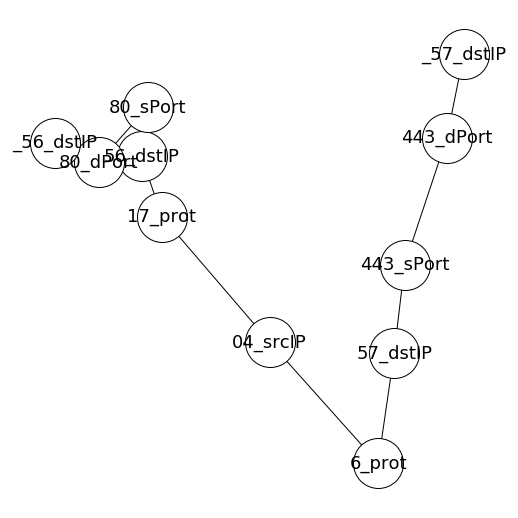

Profile graphlet


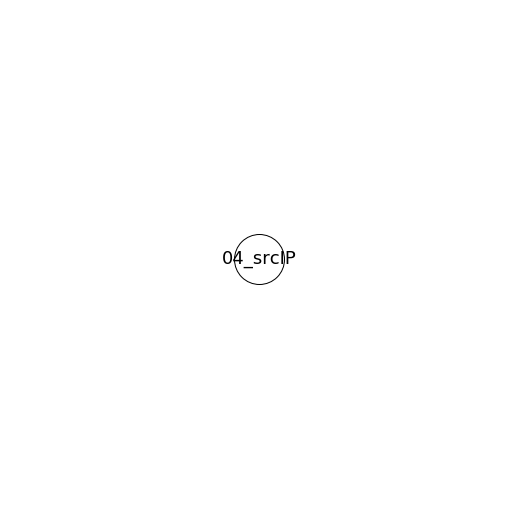

,srcIP,protocol,sPort,dPort,dstIP,_dstIP
srcIP,,,,,,
05,05_srcIP,17_prot,1035_sPort,80_dPort,56_dstIP,_56_dstIP


Activity graphlet


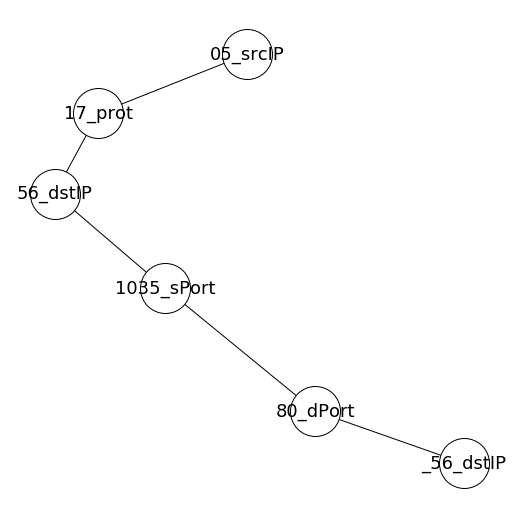

Profile graphlet


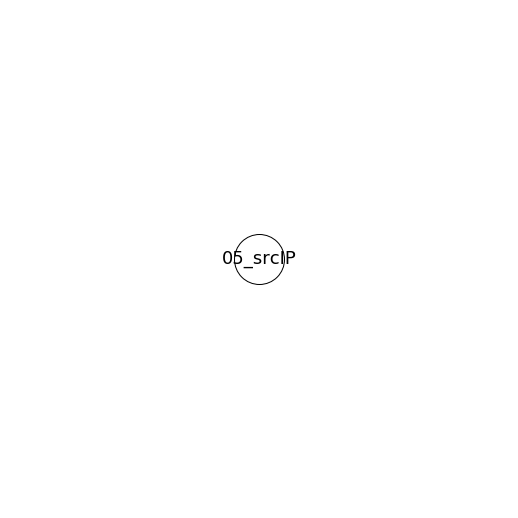

,srcIP,protocol,sPort,dPort,dstIP,_dstIP
srcIP,,,,,,
06,06_srcIP,6_prot,80_sPort,80_dPort,58_dstIP,_58_dstIP


Activity graphlet


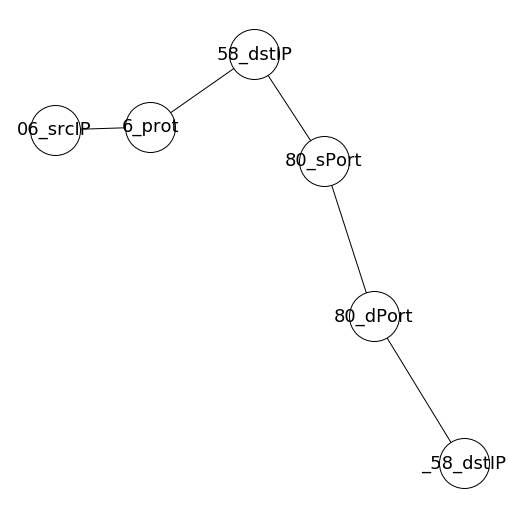

Profile graphlet


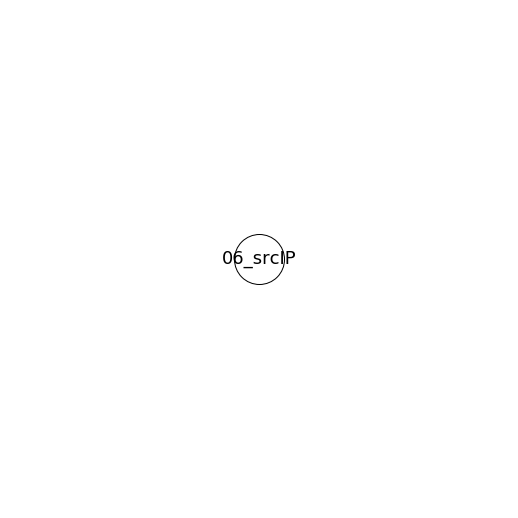

,srcIP,protocol,sPort,dPort,dstIP,_dstIP
srcIP,,,,,,
07,07_srcIP,6_prot,138_sPort,138_dPort,56_dstIP,_56_dstIP


Activity graphlet


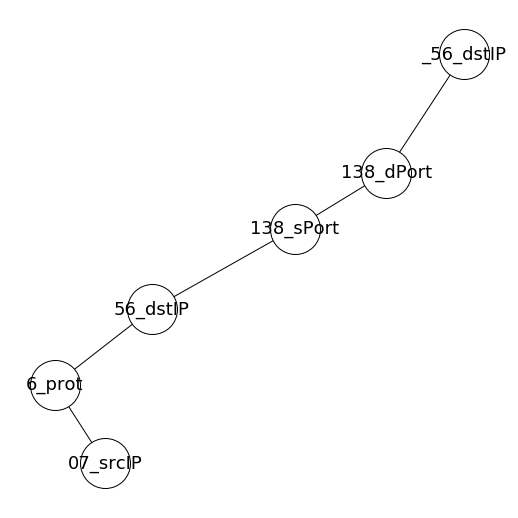

Profile graphlet


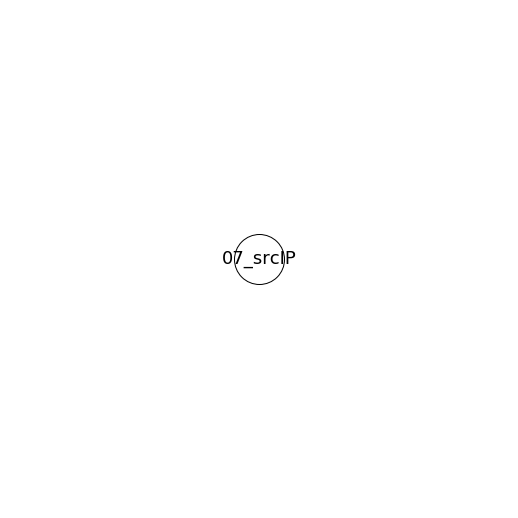

In [331]:
activity_graphlets, profile_graphlets, src_ips = build_graphlets(sample_df)

for graphlet, profile_graphlet, src_ip in zip(activity_graphlets, profile_graphlets,  src_ips):
  display(sample_df.loc[[src_ip]])
  print('Activity graphlet')
  draw_graphlet(graphlet)
  plt.show()
  print('Profile graphlet')
  draw_graphlet(profile_graphlet)
  plt.show()


In [0]:
def load_df(name):
  df = pd.read_csv(name, index_col=None,header=None, dtype=str, names=['srcIP', 'dstIP', 'protocol', 'sPort', 'dPort', 'ans'])
  return df

def get_y(df, src_ips):
  y = []
  for src_ip in src_ips:
      y.append((df.loc[[src_ip]]['ans'] == 'anomaly').any())
  return pd.Series(y, index=src_ips)


df = preprocess_df(load_df('annotated-trace.csv'))
test_df = preprocess_df(load_df('not-annotated-trace.csv'))

## Example of activity and profile graphlet for ip 944

,srcIP,protocol,dstIP,sPort,dPort,_dstIP
srcIP,,,,,,
944,944_srcIP,17_prot,17_dstIP,80_sPort,53_dPort,_17_dstIP
944,944_srcIP,17_prot,581_dstIP,443_sPort,80_dPort,_581_dstIP
944,944_srcIP,6_prot,383_dstIP,80_sPort,20_dPort,_383_dstIP
944,944_srcIP,6_prot,789_dstIP,22_sPort,443_dPort,_789_dstIP
944,944_srcIP,17_prot,500_dstIP,20_sPort,80_dPort,_500_dstIP
944,944_srcIP,17_prot,631_dstIP,80_sPort,80_dPort,_631_dstIP


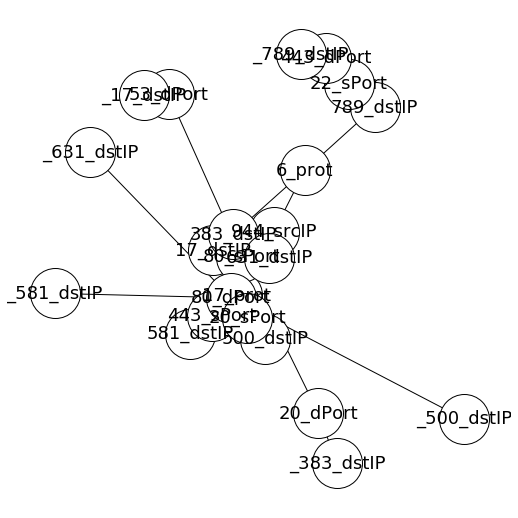

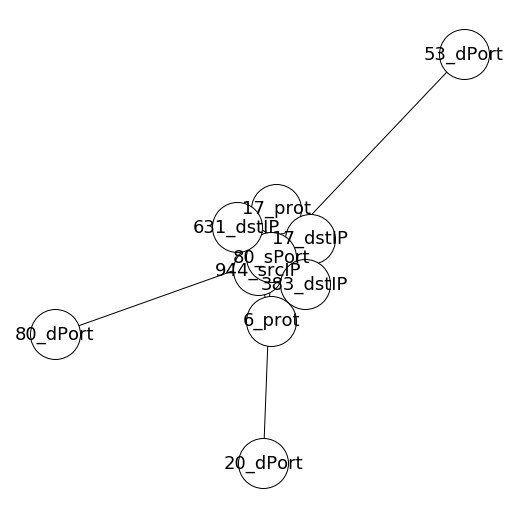

In [333]:
df_ = df[['srcIP', 'protocol', 'dstIP', 'sPort', 'dPort', '_dstIP']].copy()
p_graphlet = build_profile_graphlet(df_.loc[['944']])
a_graphlet = build_activity_graphlet(df_.loc[['944']])
    
display(df_.loc[['944']])
draw_graphlet(a_graphlet)
draw_graphlet(p_graphlet)

# For our experiments we will use all malicneous examples and 100 normal examples

In [334]:
anomaly = (df['ans']=='anomaly').groupby(df.index).any()
anomaly_src_ips = anomaly.index[anomaly].tolist()
anomaly_src_ips[:10]

['118', '156', '160', '1907', '274', '278', '294', '332', '335', '340']

In [335]:
np.random.seed(42)
random_not_anomaly_src_ips  = np.random.choice(anomaly.index[anomaly == False], 100).tolist()
random_not_anomaly_src_ips[:10]

['193', '506', '915', '350', '197', '165', '761', '116', '679', '21']

In [0]:
src_ips = list(set(anomaly_src_ips + random_not_anomaly_src_ips))

In [337]:
df.loc[src_ips].shape

(1541, 7)

In [338]:
activity_graphlets, profile_graphlets, src_ips = build_graphlets(df.loc[src_ips])
y = get_y(df, src_ips)




  0%|          | 0/154 [00:00<?, ?it/s]


 23%|██▎       | 36/154 [00:00<00:02, 51.06it/s]


 59%|█████▉    | 91/154 [00:00<00:00, 70.14it/s]


 93%|█████████▎| 143/154 [00:00<00:00, 94.59it/s]


100%|██████████| 154/154 [00:00<00:00, 164.21it/s]

In [339]:
len(df.loc[src_ips].index.unique())

154

,srcIP,dstIP,protocol,sPort,dPort,ans,_dstIP
srcIP,,,,,,,
543,543_srcIP,779_dstIP,17_prot,23_sPort,25_dPort,normal,_779_dstIP
543,543_srcIP,938_dstIP,17_prot,22_sPort,80_dPort,normal,_938_dstIP
543,543_srcIP,151_dstIP,17_prot,68_sPort,443_dPort,normal,_151_dstIP
543,543_srcIP,231_dstIP,17_prot,68_sPort,23_dPort,normal,_231_dstIP
543,543_srcIP,148_dstIP,6_prot,25_sPort,22_dPort,normal,_148_dstIP
543,543_srcIP,34_dstIP,6_prot,443_sPort,443_dPort,normal,_34_dstIP
543,543_srcIP,1000_dstIP,6_prot,53_sPort,25_dPort,normal,_1000_dstIP
543,543_srcIP,721_dstIP,1_prot,53_sPort,22_dPort,normal,_721_dstIP
543,543_srcIP,676_dstIP,17_prot,80_sPort,80_dPort,normal,_676_dstIP


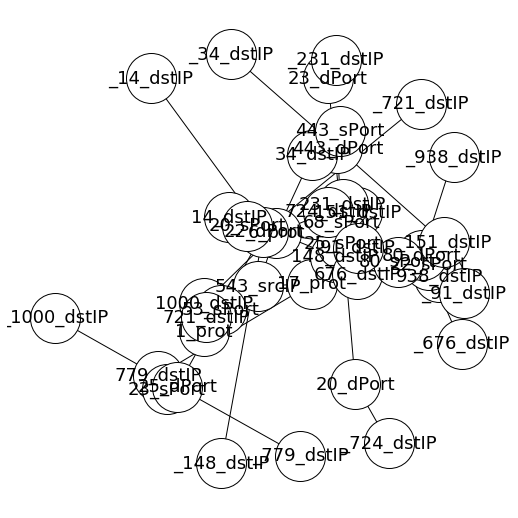

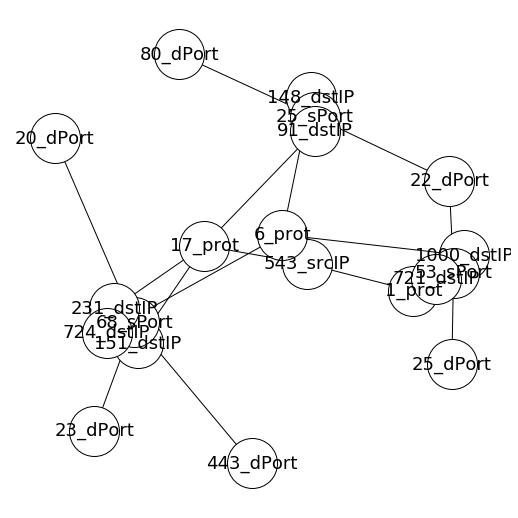

,srcIP,dstIP,protocol,sPort,dPort,ans,_dstIP
srcIP,,,,,,,
630,630_srcIP,921_dstIP,1_prot,20_sPort,443_dPort,normal,_921_dstIP
630,630_srcIP,645_dstIP,17_prot,53_sPort,23_dPort,normal,_645_dstIP
630,630_srcIP,69_dstIP,17_prot,20_sPort,20_dPort,normal,_69_dstIP
630,630_srcIP,949_dstIP,17_prot,53_sPort,20_dPort,normal,_949_dstIP
630,630_srcIP,464_dstIP,6_prot,80_sPort,80_dPort,normal,_464_dstIP
630,630_srcIP,371_dstIP,17_prot,25_sPort,22_dPort,normal,_371_dstIP
630,630_srcIP,63_dstIP,17_prot,443_sPort,22_dPort,normal,_63_dstIP
630,630_srcIP,717_dstIP,17_prot,53_sPort,25_dPort,normal,_717_dstIP
630,630_srcIP,846_dstIP,17_prot,22_sPort,22_dPort,normal,_846_dstIP


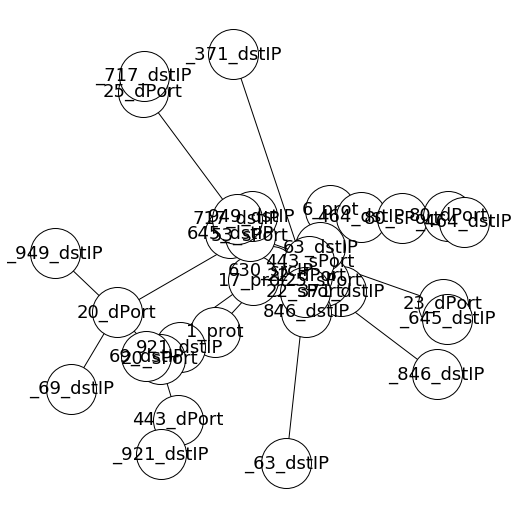

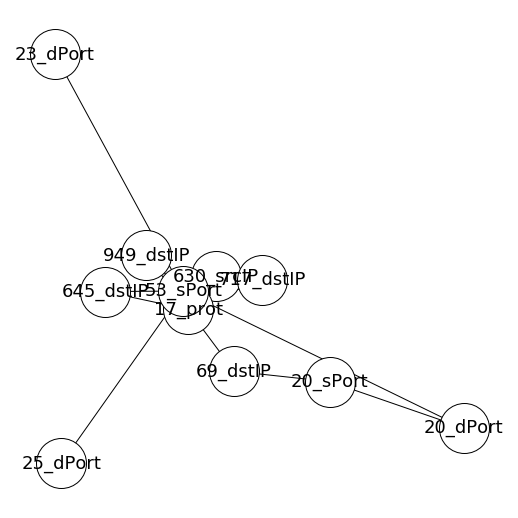

,srcIP,dstIP,protocol,sPort,dPort,ans,_dstIP
srcIP,,,,,,,
766,766_srcIP,403_dstIP,17_prot,22_sPort,20_dPort,normal,_403_dstIP
766,766_srcIP,289_dstIP,6_prot,53_sPort,25_dPort,normal,_289_dstIP
766,766_srcIP,242_dstIP,1_prot,53_sPort,443_dPort,normal,_242_dstIP
766,766_srcIP,491_dstIP,6_prot,25_sPort,53_dPort,normal,_491_dstIP
766,766_srcIP,275_dstIP,6_prot,79_sPort,80_dPort,anomaly,_275_dstIP
766,766_srcIP,693_dstIP,6_prot,80_sPort,53_dPort,normal,_693_dstIP
766,766_srcIP,746_dstIP,6_prot,53_sPort,80_dPort,normal,_746_dstIP


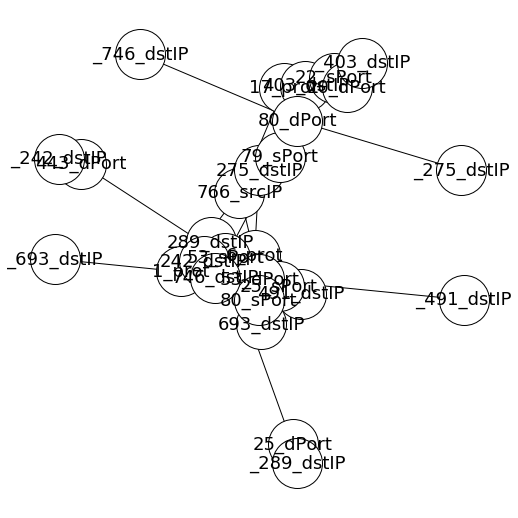

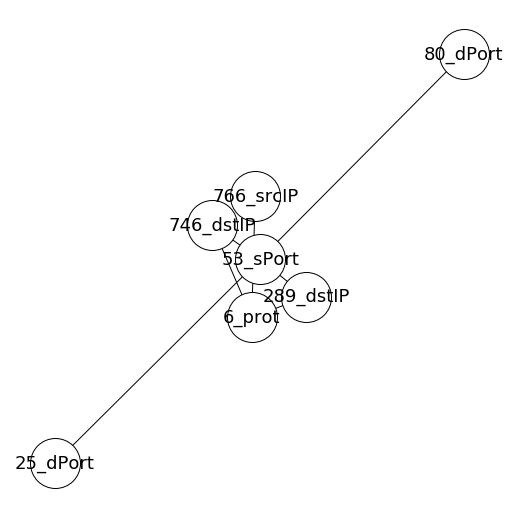

,srcIP,dstIP,protocol,sPort,dPort,ans,_dstIP
srcIP,,,,,,,
647,647_srcIP,864_dstIP,17_prot,443_sPort,79_dPort,normal,_864_dstIP
647,647_srcIP,630_dstIP,17_prot,80_sPort,443_dPort,normal,_630_dstIP
647,647_srcIP,708_dstIP,17_prot,443_sPort,53_dPort,normal,_708_dstIP
647,647_srcIP,806_dstIP,17_prot,25_sPort,10_dPort,anomaly,_806_dstIP
647,647_srcIP,906_dstIP,6_prot,22_sPort,22_dPort,normal,_906_dstIP
647,647_srcIP,708_dstIP,17_prot,23_sPort,80_dPort,normal,_708_dstIP
647,647_srcIP,275_dstIP,17_prot,25_sPort,53_dPort,normal,_275_dstIP
647,647_srcIP,39_dstIP,6_prot,80_sPort,53_dPort,normal,_39_dstIP


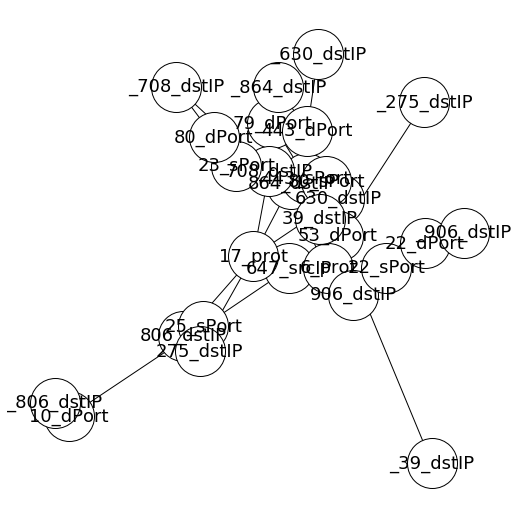

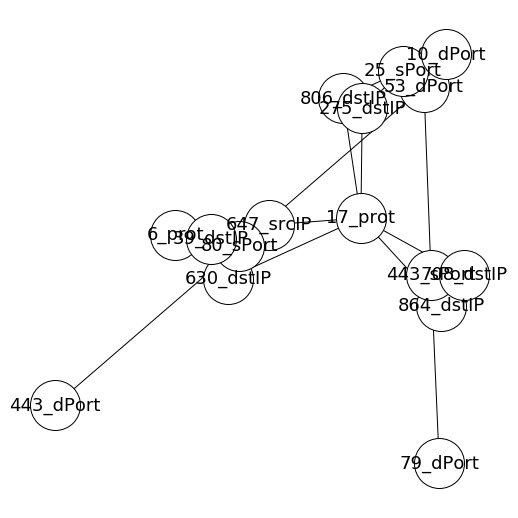

,srcIP,dstIP,protocol,sPort,dPort,ans,_dstIP
srcIP,,,,,,,
835,835_srcIP,984_dstIP,17_prot,23_sPort,53_dPort,normal,_984_dstIP
835,835_srcIP,978_dstIP,17_prot,53_sPort,53_dPort,normal,_978_dstIP
835,835_srcIP,877_dstIP,6_prot,23_sPort,53_dPort,normal,_877_dstIP
835,835_srcIP,500_dstIP,1_prot,443_sPort,53_dPort,normal,_500_dstIP
835,835_srcIP,41_dstIP,1_prot,80_sPort,22_dPort,normal,_41_dstIP
835,835_srcIP,806_dstIP,17_prot,443_sPort,15_dPort,anomaly,_806_dstIP


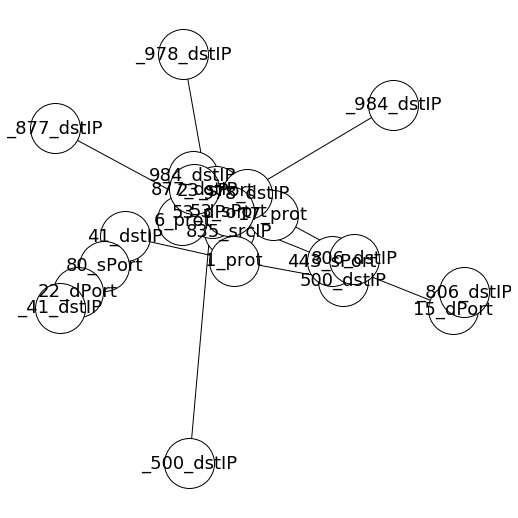

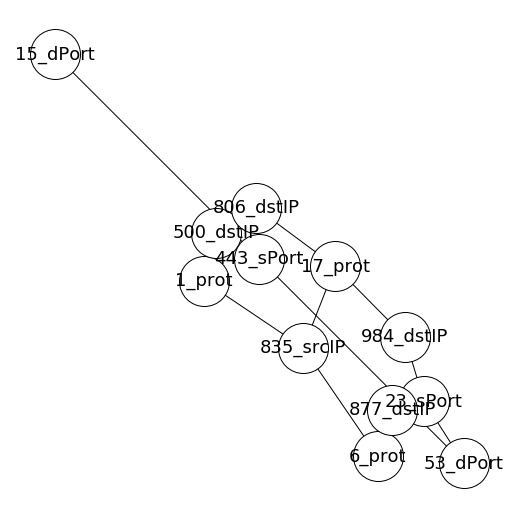

,srcIP,dstIP,protocol,sPort,dPort,ans,_dstIP
srcIP,,,,,,,
402,402_srcIP,806_dstIP,17_prot,53_sPort,27_dPort,anomaly,_806_dstIP
402,402_srcIP,128_dstIP,6_prot,20_sPort,20_dPort,normal,_128_dstIP
402,402_srcIP,7_dstIP,1_prot,443_sPort,23_dPort,normal,_7_dstIP
402,402_srcIP,657_dstIP,6_prot,53_sPort,53_dPort,normal,_657_dstIP
402,402_srcIP,574_dstIP,6_prot,68_sPort,20_dPort,normal,_574_dstIP
402,402_srcIP,500_dstIP,6_prot,23_sPort,53_dPort,normal,_500_dstIP
402,402_srcIP,654_dstIP,1_prot,23_sPort,443_dPort,normal,_654_dstIP
402,402_srcIP,618_dstIP,17_prot,25_sPort,53_dPort,normal,_618_dstIP
402,402_srcIP,124_dstIP,17_prot,25_sPort,20_dPort,normal,_124_dstIP


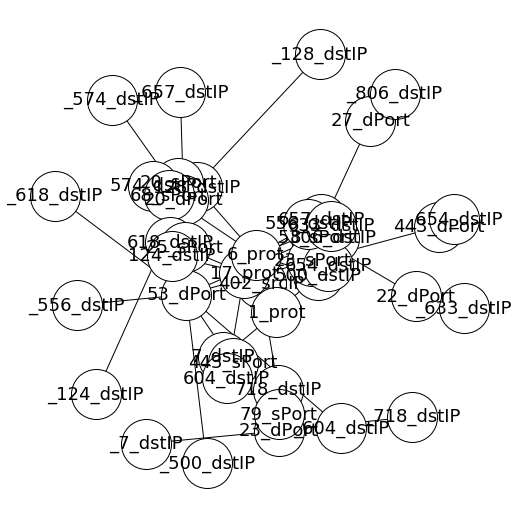

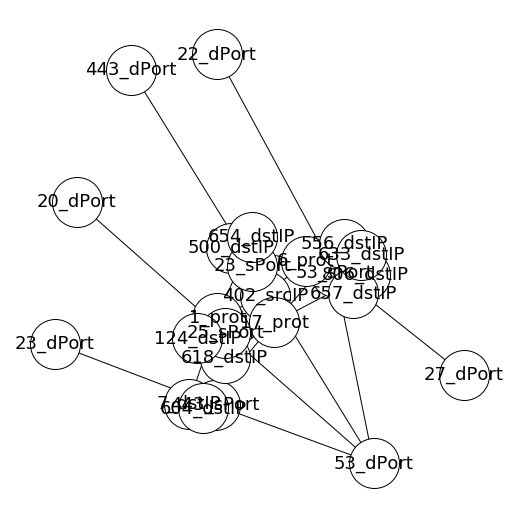

,srcIP,dstIP,protocol,sPort,dPort,ans,_dstIP
srcIP,,,,,,,
550,550_srcIP,322_dstIP,17_prot,23_sPort,53_dPort,normal,_322_dstIP
550,550_srcIP,122_dstIP,17_prot,23_sPort,53_dPort,normal,_122_dstIP
550,550_srcIP,162_dstIP,17_prot,53_sPort,23_dPort,normal,_162_dstIP
550,550_srcIP,275_dstIP,6_prot,443_sPort,80_dPort,anomaly,_275_dstIP
550,550_srcIP,993_dstIP,6_prot,20_sPort,23_dPort,normal,_993_dstIP
550,550_srcIP,854_dstIP,17_prot,53_sPort,20_dPort,normal,_854_dstIP
550,550_srcIP,524_dstIP,17_prot,20_sPort,53_dPort,normal,_524_dstIP
550,550_srcIP,325_dstIP,6_prot,53_sPort,80_dPort,normal,_325_dstIP


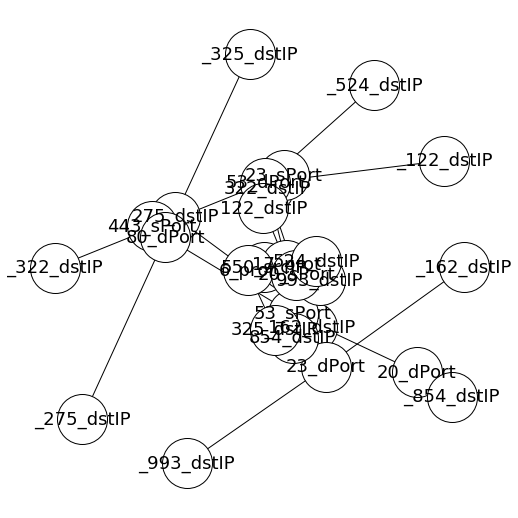

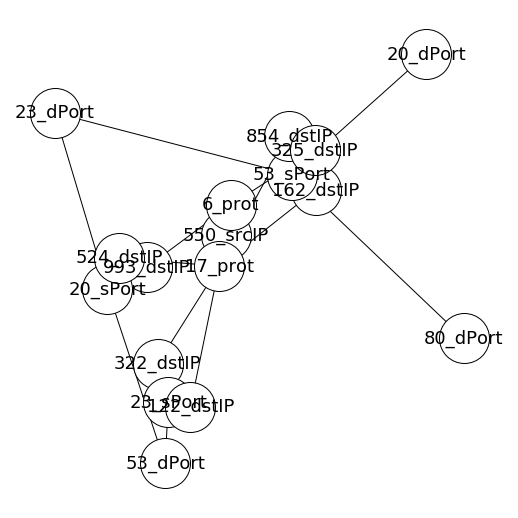

,srcIP,dstIP,protocol,sPort,dPort,ans,_dstIP
srcIP,,,,,,,
759,759_srcIP,959_dstIP,17_prot,68_sPort,79_dPort,normal,_959_dstIP
759,759_srcIP,364_dstIP,17_prot,23_sPort,53_dPort,normal,_364_dstIP
759,759_srcIP,806_dstIP,17_prot,23_sPort,13_dPort,anomaly,_806_dstIP
759,759_srcIP,306_dstIP,6_prot,23_sPort,23_dPort,normal,_306_dstIP
759,759_srcIP,447_dstIP,6_prot,20_sPort,80_dPort,normal,_447_dstIP
759,759_srcIP,418_dstIP,17_prot,443_sPort,80_dPort,normal,_418_dstIP
759,759_srcIP,539_dstIP,17_prot,80_sPort,80_dPort,normal,_539_dstIP
759,759_srcIP,443_dstIP,17_prot,443_sPort,53_dPort,normal,_443_dstIP
759,759_srcIP,291_dstIP,6_prot,53_sPort,22_dPort,normal,_291_dstIP


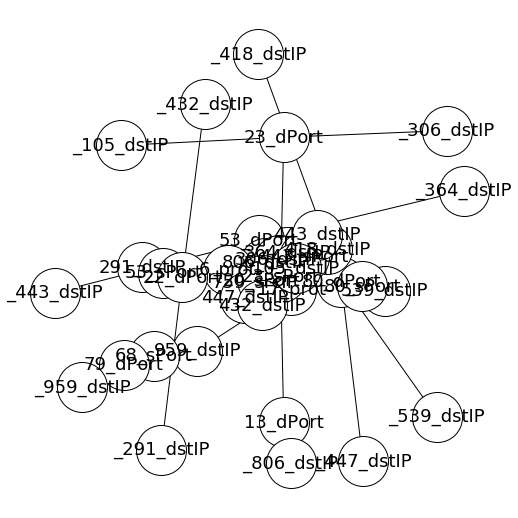

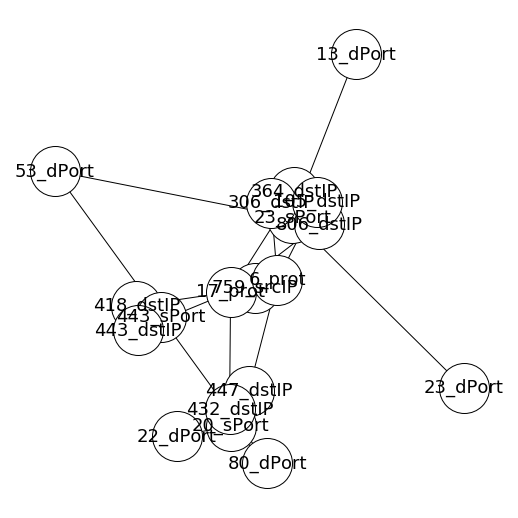

,srcIP,dstIP,protocol,sPort,dPort,ans,_dstIP
srcIP,,,,,,,
912,912_srcIP,426_dstIP,6_prot,80_sPort,80_dPort,normal,_426_dstIP
912,912_srcIP,806_dstIP,17_prot,53_sPort,9_dPort,anomaly,_806_dstIP
912,912_srcIP,663_dstIP,6_prot,53_sPort,20_dPort,normal,_663_dstIP
912,912_srcIP,89_dstIP,17_prot,79_sPort,20_dPort,normal,_89_dstIP
912,912_srcIP,24_dstIP,6_prot,20_sPort,80_dPort,normal,_24_dstIP
912,912_srcIP,555_dstIP,17_prot,25_sPort,443_dPort,normal,_555_dstIP


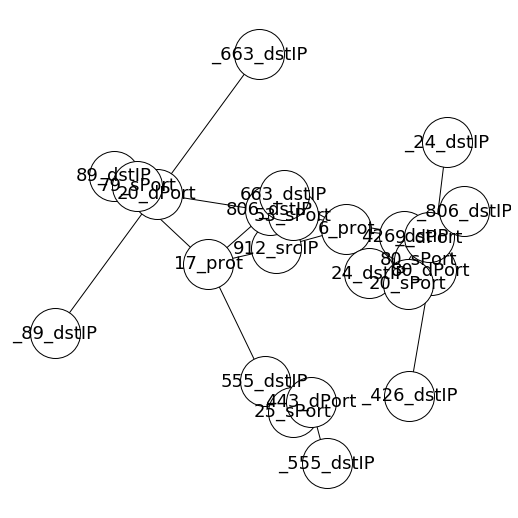

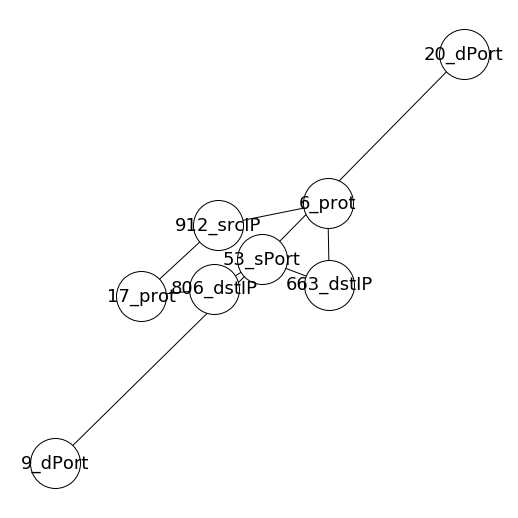

,srcIP,dstIP,protocol,sPort,dPort,ans,_dstIP
srcIP,,,,,,,
342,342_srcIP,761_dstIP,6_prot,53_sPort,53_dPort,normal,_761_dstIP
342,342_srcIP,273_dstIP,17_prot,80_sPort,22_dPort,normal,_273_dstIP
342,342_srcIP,436_dstIP,6_prot,20_sPort,53_dPort,normal,_436_dstIP
342,342_srcIP,911_dstIP,1_prot,23_sPort,79_dPort,normal,_911_dstIP
342,342_srcIP,863_dstIP,89_prot,80_sPort,22_dPort,normal,_863_dstIP
342,342_srcIP,846_dstIP,6_prot,25_sPort,53_dPort,normal,_846_dstIP
342,342_srcIP,213_dstIP,6_prot,80_sPort,68_dPort,normal,_213_dstIP
342,342_srcIP,243_dstIP,17_prot,79_sPort,23_dPort,normal,_243_dstIP
342,342_srcIP,872_dstIP,6_prot,20_sPort,80_dPort,normal,_872_dstIP


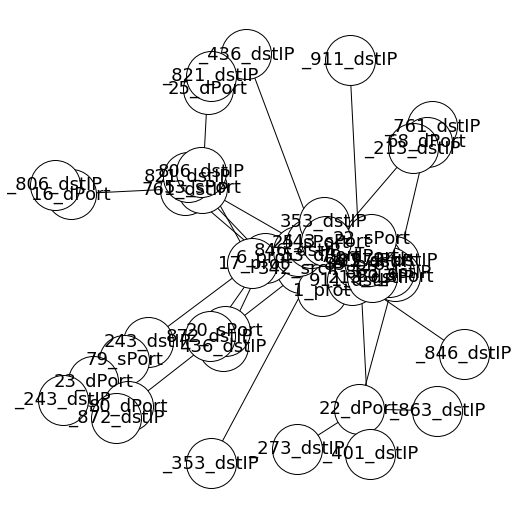

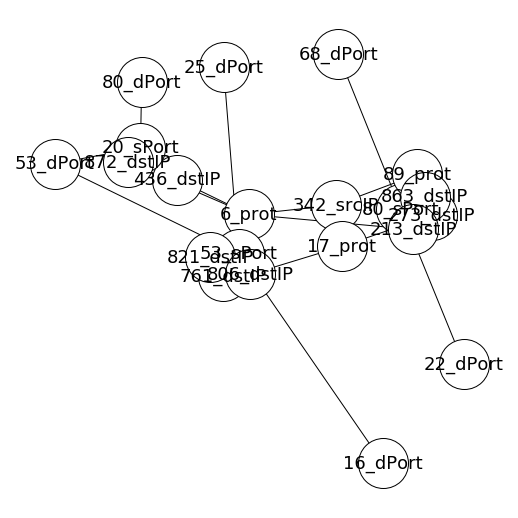

In [340]:
for activity_graphlet, graphlet, src_ip in zip(activity_graphlets[:10], profile_graphlets[:10], src_ips[:10]):
  display(df.loc[[src_ip]])
  draw_graphlet(activity_graphlet)

  draw_graphlet(graphlet)


In [341]:
_, test_profile_graphlets,  test_src_ips = build_graphlets(test_df.loc[src_ips])




  0%|          | 0/154 [00:00<?, ?it/s]


 26%|██▌       | 40/154 [00:00<00:00, 390.99it/s]


 51%|█████▏    | 79/154 [00:00<00:00, 386.49it/s]


 72%|███████▏  | 111/154 [00:00<00:00, 176.24it/s]


 97%|█████████▋| 150/154 [00:00<00:00, 210.78it/s]


100%|██████████| 154/154 [00:00<00:00, 209.65it/s]

# Our random walk kernel approach with kernel trick

In [0]:
import itertools

def graph_product(g1, g2):
  g1 = nx.relabel_nodes(g1, lambda x: str(x))   
  g2 = nx.relabel_nodes(g2, lambda x: str(x) +"'")    
  g_prod = nx.DiGraph(nx.empty_graph())
  nodes_prod = list(itertools.product(g1.nodes(), g2.nodes()))
  g_prod.add_nodes_from(nodes_prod)

  
  for (i1, i2) in nodes_prod:
    for (j1, j2) in nodes_prod:
      if (i1, j1) in g1.edges() and (i2, j2) in g2.edges():
        g_prod.add_edge((i1, i2), (j1, j2))
  
  return g_prod
  
def random_walk_kernel(g1, g2):
  g = graph_product(g1, g2)
  A = nx.adjacency_matrix(g).toarray()
  n = A.shape[0]
  lamb = 1e-42
  I = np.identity(n)
  e = np.ones(n)
  K = e.T.dot(np.linalg.pinv(I-lamb*A)).dot(e)
  return np.squeeze(K)


# Using Kernel trick

In [0]:
def compute_similarity_matrix(a, b=None, kernel=None):
  n = len(a)

  if b:
    m =  len(b)
    sim_matrix = np.zeros((n,m))
    for i in tqdm(range(n)):
      for j in range(m):
        sim_matrix[i,j] = kernel(a[i], b[j])
  else:
    sim_matrix = np.zeros((n,n))
    for i in tqdm(range(n)):
      for j in range(i+1):
        sim_matrix[i,j] = sim_matrix[j,i] = kernel(a[i], a[j])

  return sim_matrix

# sim_matrix = compute_similarity_matrix(profile_graphlets, kernel=random_walk_kernel)

sim_matrix = np.load('sim_matrix.npy')
# np.save('sim_matrix.npy', sim_matrix)

In [345]:
sim_matrix.shape

(154, 154)

In [346]:
len(src_ips)

154

In [348]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

svc = SVC(kernel='precomputed')

parameters = {'C':list(range(30)), 'gamma':[0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7]}

clf = GridSearchCV(svc, parameters, scoring=['f1', 'accuracy', 'precision', 'recall'], refit='f1', n_jobs=-1, verbose=1)
clf.fit(sim_matrix, y)
print('k', k)
print('clf.best_score_', clf.best_score_)
print('clf.best_params_', clf.best_params_)

Fitting 5 folds for each of 330 candidates, totalling 1650 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:    3.7s


KeyboardInterrupt: ignored

In [0]:
test_sim_matrix = compute_similarity_matrix(test_profile_graphlets, profile_graphlets, kernel=random_walk_kernel)

In [0]:
clf.predict(test_sim_matrix)

# Without kernel trick

In [0]:
from numpy.linalg import matrix_power

def random_walk_kernel_of_lengh_k(g, k=4):
  A = nx.adjacency_matrix(g).toarray()
  return [matrix_power(A, i).sum() for i in range(k+1)]


In [0]:
activity_graphlets, profile_graphlets, src_ips = build_graphlets(df)
y = get_y(df, src_ips)

In [0]:
test_activity_graphlets, test_profile_graphlets, test_src_ips = build_graphlets(test_df)
 

In [0]:
def get_features(graphlets, k=4):
  return np.array([random_walk_kernel_of_lengh_k(g, k=k) for g in tqdm(graphlets)])

In [0]:
features = get_features(profile_graphlets, k=100)
test_features = get_features(test_profile_graphlets, k=100)

In [0]:
from sklearn.decomposition import KernelPCA

#“linear” | “poly” | “rbf” | “sigmoid” | “cosine” 

pca = KernelPCA(n_components=2, kernel='linear')

X_transformed = pca.fit_transform(features)

plt.figure(figsize=(12,12))
plt.grid()
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=y);

In [0]:
def build_profile_graphlet(df):
  activity_g = build_activity_graphlet(df)

  neigs_of_sig_nodes = [node for sig_node in get_significant_set(activity_g) for node in activity_g.neighbors(sig_node)]
  nodes_for_profile =  set(neigs_of_sig_nodes + get_significant_set(activity_g))
  
  g = nx.DiGraph()
  g.add_node(df.values[0][0])

  for flow in df.values:   
    if can_be_added(nodes_for_profile, flow): 
      for i in range(len(flow) - 1):
        g.add_edge(flow[i], flow[i + 1])
  
  return g

# Parameters tuning

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

for k in [4, 10, 20, 50, 100]:
  features = get_features(profile_graphlets, k=k)
  test_features = get_features(test_profile_graphlets, k=k)

  svc = SVC(kernel='rbf')

  parameters = {'C':list(range(30)), 'gamma':[0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7]}

  clf = GridSearchCV(svc, parameters, scoring=['f1', 'accuracy', 'precision', 'recall'], refit='f1', n_jobs=-1, verbose=1)
  clf.fit(features, y)
  print('k', k)
  print('clf.best_score_', clf.best_score_)
  print('clf.best_params_', clf.best_params_)
  print('clf.best_index_', clf.best_index_)
  print('clf.cv_results_', clf.cv_results_)

In [0]:
clf.best_score_

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

features = get_features(profile_graphlets, k=4)
test_features = get_features(test_profile_graphlets, k=4)

# Prediction

In [0]:
svc = SVC(kernel='rbf', C=6, gamma=0.15)
svc.fit(features, y)

pred = svc.predict(test_features)

# cross_validate(svc, features, y)

In [0]:
np.nonzero(pred)

In [0]:
np.nonzero(y)

# Anomaly analysis

In [0]:
import matplotlib.pyplot as plt
import networkx as nx

try:
    import pygraphviz
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import graphviz_layout
    except ImportError:
        raise ImportError("This example needs Graphviz and either "
                          "PyGraphviz or pydot")


l = [ 17,  39,  45,  63,  65,  66, 120, 140, 157, 159, 169, 170, 190,
        192, 193, 196, 247, 255, 268, 286, 292, 295, 297, 298, 299, 301,
        313, 322, 335, 342, 398, 432, 458, 462, 480, 489, 502, 507, 521,
        582, 597, 599, 612, 670, 676, 678, 718, 746, 755, 765, 779, 895,
        906, 907, 924, 937, 967, 988]
i = 45

for i in l:
  G = profile_graphlets[i]

  display(df.loc[src_ips[i]])

  # pos = graphviz_layout(G, prog='twopi')
  pos = graphviz_layout(G, prog='dot')

  plt.figure(figsize=(15, 10))
  nx.draw(G, pos, node_size=2500, alpha=0.5, node_color="blue", with_labels=False)
  # plt.axis('equal')
  # plt.show()


  nx.draw_networkx_labels(G, pos=pos, font_size=18)
  nx.draw_networkx_nodes(G,pos, node_color='white', node_size=2500, edgecolors='black')
  plt.show()

# Ideal kernel

In [0]:
!pip install grakel

In [0]:
adj_matrices = [graph_from_networkx(profile_graphlets) for g in profile_graphlets]
test_adj_matrices = [graph_from_networkx(g) for g in test_profile_graphlets]

In [0]:
nx.set_node_attributes(profile_graphlets[0], 'labels', '2')

In [0]:
anomaly = (df['ans']=='anomaly').groupby(df.index).any()
anomaly_src_ips = anomaly.index[anomaly].tolist()
anomaly_src_ips[:10]

np.random.seed(42)
random_not_anomaly_src_ips  = np.random.permutation(anomaly.index[anomaly == False]).tolist()[:50]
random_not_anomaly_src_ips[:10]

In [0]:
src_ips = list(set(anomaly_src_ips + random_not_anomaly_src_ips))

activity_graphlets, profile_graphlets, src_ips = build_graphlets(df.loc[src_ips])
y = get_y(df, src_ips)

# Parameters tuning

In [0]:
from  grakel import SubgraphMatching
kernel = SubgraphMatching(k=5, verbose=True)

G_nx = []
new_src_ips = []

for i in range(len(profile_graphlets)):
  if len(profile_graphlets[i].edges()) > 0:
    G2 = nx.from_numpy_matrix(nx.adjacency_matrix(profile_graphlets[i]).toarray())
    nx.set_node_attributes(G2, 'label', 'label')
    nx.set_edge_attributes(G2, 'label', 'label')
    G_nx.append(G2)
    new_src_ips.append(src_ips[i])

print('a')

new_graphlets = graph_from_networkx(G_nx, node_labels_tag='label', edge_labels_tag='label')

sim_matrix = kernel.fit_transform(new_graphlets)

In [0]:
sim_matrix.shape

In [0]:
len(new_src_ips)

In [0]:
y = y.loc[new_src_ips]

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

svc = SVC(kernel='precomputed')

parameters = {'C': [3], 'gamma':[0.001, 0.01,  0.1, 0.5]}

clf = GridSearchCV(svc, parameters, scoring=['f1', 'accuracy', 'precision', 'recall'], refit='f1', n_jobs=-1, verbose=1, cv=3)

clf.fit(sim_matrix, y)
print('k', k)
print('clf.best_score_', clf.best_score_)
print('clf.best_params_', clf.best_params_)